In [9]:
import os
import sys
sys.path.append('/home/kal/TF_models/bin/')
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Must be before importing keras!

import tf_memory_limit
from keras.models import load_model 
import tensorflow as tf

import numpy as np
import matplotlib.pylab as plt 
from sklearn.metrics import precision_recall_curve
from tqdm import tqdm
import ucscgenome
import math

import bisect
import pandas as pd

import sequence
import train_TFmodel
import eval_TFmodel
import ctcfgen
import seq_only_gen

In [3]:
# get the generator
gen = seq_only_gen.TFGenerator('/home/kal/TF_models/seq_only/ctcfgen.hdf5')
g = gen.pair_gen(mode='val')
print(len(gen.val_pos))

3653


In [4]:
# get the model
sig = eval_TFmodel.TFmodel('/home/kal/TF_models/seq_only/seq_classifier/20170919_sigmoid_model/')
reg = eval_TFmodel.TFmodel('/home/kal/TF_models/seq_only/seq_regression/20170920_regression_model/')
pwm = eval_TFmodel.TFmodel('/home/kal/TF_models/seq_only/seq_classifier/pwm_frozen/')

Loading model without Bias layer


In [32]:
# predict on test sequences and make a p-r and p-r gain curve
true_labels = list()
sig_preds = list()
reg_preds = list()
pwm_preds = list()
sequence_list = list()
for i in tqdm(range(len(gen.val_pos))):
    batch, labels = next(g)
    true_labels.append(labels)
    sig_preds.append(sig.get_activation(iter(batch)))
    reg_preds.append(reg.model.predict(batch))
    pwm_preds.append(pwm.model.predict(batch))
    sequence_list.append(batch)
    
    
true_labels = np.asarray(true_labels).flatten().tolist()
sig_preds = np.asarray(sig_preds).flatten().tolist()
reg_preds = np.asarray(reg_preds).flatten().tolist()
pwm_preds = np.asarray(pwm_preds).flatten().tolist()

100%|██████████| 3653/3653 [07:33<00:00,  8.04it/s]


In [40]:
# make a dataframe
sequence_list = np.asarray(sequence_list).reshape((-1, 256, 4))
sequence_list = [sequence.encode_to_string(seq) for seq in sequence_list]
data = {'seq':sequence_list, 'ctcf': true_labels, 'pwm': pwm_preds, 'sig_ml': sig_preds}
peaks = pd.DataFrame(data)

ValueError: cannot reshape array of size 116896 into shape (256,4)

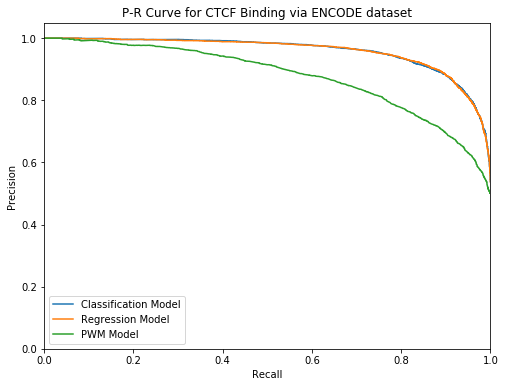

In [34]:
#p-r curve
sig_p, sig_r, sig_t = precision_recall_curve(true_labels, sig_preds, pos_label=1)
pwm_p, pwm_r, pwm_t = precision_recall_curve(true_labels, pwm_preds, pos_label=1)
reg_p, reg_r, reg_t = precision_recall_curve(true_labels, reg_preds, pos_label=1)

plt.figure(figsize=(8,6))
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('P-R Curve for CTCF Binding via ENCODE dataset')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(sig_r, sig_p, label='Classification Model')
plt.plot(reg_r, reg_p, label='Regression Model')
plt.plot(pwm_r, pwm_p, label='PWM Model')
plt.legend()
plt.show()

/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in double_scalars
/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in double_scalars
/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in double_scalars


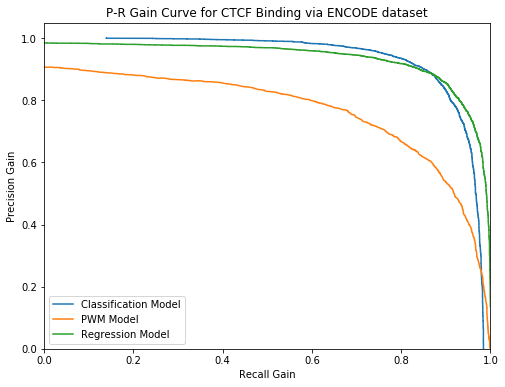

In [35]:
#p-r gain gurve
# we consider only p/r value between prop_pos and 1
prop_pos = sum(true_labels)/len(true_labels)

sig_pgain = [(x-prop_pos)/((1-prop_pos)*x) for x in sig_p]
sig_rgain = [(x-prop_pos)/((1-prop_pos)*x) for x in sig_r]
reg_pgain = [(x-prop_pos)/((1-prop_pos)*x) for x in reg_p]
reg_rgain = [(x-prop_pos)/((1-prop_pos)*x) for x in reg_r]
pwm_pgain = [(x-prop_pos)/((1-prop_pos)*x) for x in pwm_p]
pwm_rgain = [(x-prop_pos)/((1-prop_pos)*x) for x in pwm_r]

plt.figure(figsize=(8,6))
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('P-R Gain Curve for CTCF Binding via ENCODE dataset')
plt.xlabel('Recall Gain')
plt.ylabel('Precision Gain')
plt.plot(sig_pgain, sig_rgain, label='Classification Model')
plt.plot(pwm_rgain, pwm_pgain, label='PWM Model')
plt.plot(reg_rgain, reg_pgain, label='Regression Model')
plt.legend()
plt.show()

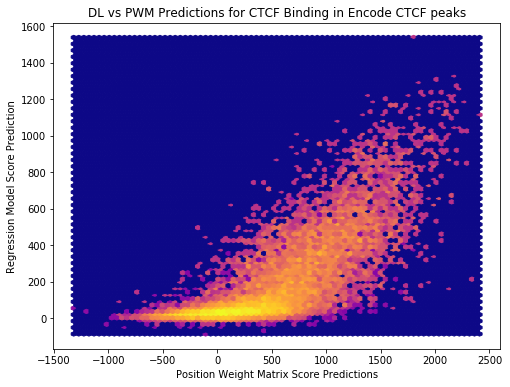

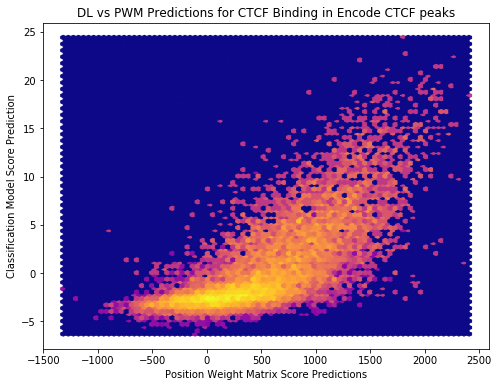

In [38]:
# make the heatmap of lore
plt.figure(figsize=(8,6))
plt.hexbin(pwm_preds, reg_preds, bins='log', cmap='plasma', gridsize=80)
plt.xlabel('Position Weight Matrix Score Predictions')
plt.ylabel('Regression Model Score Prediction')
plt.title('DL vs PWM Predictions for CTCF Binding in Encode CTCF peaks')
plt.show()

# make the heatmap of lore
plt.figure(figsize=(8,6))
plt.hexbin(pwm_preds, sig_preds, bins='log', cmap='plasma', gridsize=80)
plt.xlabel('Position Weight Matrix Score Predictions')
plt.ylabel('Classification Model Score Prediction')
plt.title('DL vs PWM Predictions for CTCF Binding in Encode CTCF peaks')
plt.show()

(207, 4)


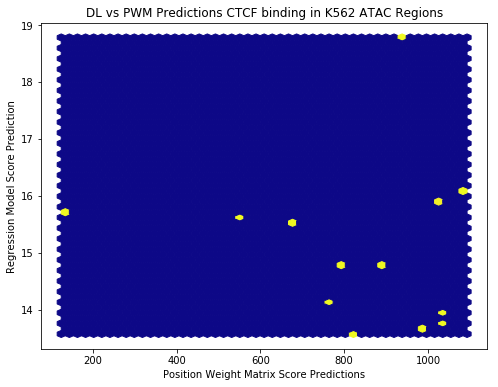

In [62]:
# get the forth quadrant seqs
# get 4th quadrant seqs
intrigue = peaks[(peaks['pwm'] < 1100)]
intrigue= intrigue[(intrigue['sig_ml'] > 13.5)]
#intrigue = intrigue[(10*intrigue['sig_ml'] - intrigue['pwm'] > 100)]
#intrigue = intrigue.sample(200)
print(intrigue.shape)

plt.figure(figsize=(8,6))
plt.hexbin(intrigue['pwm'].tolist(), intrigue['sig_ml'].tolist(), bins='log', cmap='plasma', gridsize=50)
plt.xlabel('Position Weight Matrix Score Predictions')
plt.ylabel('Regression Model Score Prediction')
plt.title('DL vs PWM Predictions CTCF binding in K562 ATAC Regions')
plt.show()

In [63]:
# write out the intereseting sequences in fasta format for further analysis
genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')
with open('/home/kal/TF_models/data/K562_atac_peaks/2nd_quad_seqs.fa', 'w') as output:
    output.write('>prediction_ml|predictions_pwm\nsequence\n')
    for index, row in intrigue.iterrows():
        output.write('>'+ str(row.name) + '|' + str(row['sig_ml']) + '-' + str(row['pwm']) + '\n')
        output.write(sequence.encode_to_string(row.seq))
        print('>'+ str(row.name) + '|' + str(row['sig_ml']) + '-' + str(row['pwm']))
        print(sequence.encode_to_string(row.seq))

>674|13.710986137390137-990.0
tatgctcagtaataagtagaagacatgattatggtgcagttacagccactggacctgggaaagaaagtcctaaatacccaggatgtttttggacccccaaactgtactatgctgaagttccactagggggtgtactggcagggtggatttgtatcttatttcctgcacatagaaccagtattttcctgagagaaagggtcttttgtaactaatctttggagtatgacaaaatctaatagtccttaagaaatagaga
>1955|13.996498107910156-1038.0
cactcttctaacatttgcaatgtttgaaaaacacacttgcaaataaaactgcccaaaatgtctgtcctttgtgagtttagtattctggtgaatcctgttcgatagtatttttattgatcagtagagggcgtgcttgactcaatataattgtaggtacagcgtgtgcacaatttagcctgggaacaacaggtcgacagctgcatgaagaaagttaagggagaaattactctatttttgtgatgttagtgaaaaggat
>2767|15.577664375305176-679.0
cgaaaaacagtttctgcaccactagtgaaagatgatgatgtattaactattatgatgcattgaccttatgcaattactatgcctcatgcctttctctgcaaatgtagtaaataattctgagcaagtccactaggaggagttcttgctacaactataaaacaaaagatagcttttgctatttgctgattgagacatttggtactttccttaattttttctgcatacttttattggcatacaaaaatgcatgctccac
>3851|16.106632232666016-1093.0
tgccttgcttgactcagtgaactcagagcagaagacgcatagtttggatgataggttggggaccactgaaaaaggtaagtgtcacatgagttgctacaggaaag

In [ ]:
# predict on all atac sequences from k562 and make a p-r and p-r gain curve
bed_path = '/home/kal/TF_models/data/K562_atac_peaks/final_atac.bed'
peaks = pandas.read_table(bed_path, header=None)
peaks.columns = 'chr start end ctcf_label . . '.split()
peaks = peaks[peaks['chr']!='chrM']
print(len(peaks))
peaks = peaks.sample(1000)

In [ ]:
pwm_preds = pwm.predict_bed(peaks)
peaks['pwm'] = pwm_preds
reg_preds = reg.predict_bed(peaks)
peaks['reg_ml'] = reg_preds
sig_preds = sig.predict_bed(peaks)
peaks['sig_ml'] = sig_preds
true_labels = peaks['ctcf_label']

In [ ]:
header = ['chr', 'start', 'end', 'ctcf_label', 'pwm', 'reg_ml', 'sig_ml']
peaks.to_csv('/home/kal/TF_models/data/encode_ctcf_annotated.bed', sep='\t', columns = header)

In [ ]:
# load the model
peaks = pandas.read_table('/home/kal/TF_models/data/encode_ctcf_annotated.bed')
columns = ['chr', 'start', 'end', 'ctcf_label', 'pwm', 'reg_ml', 'sig_ml']
true_labels = peaks['ctcf_label']

In [ ]:
#p-r curve
sig_p, sig_r, sig_t = precision_recall_curve(peaks['ctcf_label'], peaks['sig_ml'], pos_label=1)
pwm_p, pwm_r, pwm_t = precision_recall_curve(peaks['ctcf_label'], peaks['pwm'], pos_label=1)
reg_p, reg_r, reg_t = precision_recall_curve(peaks['ctcf_label'], peaks['reg_ml'], pos_label=1)

plt.figure(figsize=(8,6))
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('P-R Curve for CTCF Binding in K562 ATAC Regions')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(sig_r, sig_p, label='Classification Model')
plt.plot(reg_r, reg_p, label='Regression Model')
plt.plot(pwm_r, pwm_p, label='PWM Model')
plt.legend()
plt.show()

In [ ]:
#p-r gain gurve
# we consider only p/r value between prop_pos and 1
prop_pos = sum(true_labels)/len(true_labels)

sig_pgain = [(x-prop_pos)/((1-prop_pos)*x) for x in sig_p]
sig_rgain = [(x-prop_pos)/((1-prop_pos)*x) for x in sig_r]
reg_pgain = [(x-prop_pos)/((1-prop_pos)*x) for x in reg_p]
reg_rgain = [(x-prop_pos)/((1-prop_pos)*x) for x in reg_r]
pwm_pgain = [(x-prop_pos)/((1-prop_pos)*x) for x in pwm_p]
pwm_rgain = [(x-prop_pos)/((1-prop_pos)*x) for x in pwm_r]

plt.figure(figsize=(8,6))
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('P-R Gain Curve for CTCF Binding in K562 ATAC Regions')
plt.xlabel('Recall Gain')
plt.ylabel('Precision Gain')
plt.plot(sig_pgain, sig_rgain, label='Classification Model')
plt.plot(reg_rgain, reg_pgain, label='Regression Model')
plt.plot(pwm_rgain, pwm_pgain, label='PWM Model')
plt.legend()
plt.show()

In [ ]:
# make the heatmap of lore
plt.figure(figsize=(8,6))
plt.hexbin(peaks['pwm'], peaks['reg_ml'], bins='log', cmap='plasma', gridsize=100)
plt.xlabel('Position Weight Matrix Score Predictions')
plt.ylabel('Regression Model Score Prediction')
plt.title('DL vs PWM Predictions CTCF binding in K562 ATAC Regions')
plt.show()

# make the heatmap of lore
plt.figure(figsize=(8,6))
plt.hexbin(peaks['pwm'], peaks['sig_ml'], bins='log', cmap='plasma', gridsize=100)
plt.xlabel('Position Weight Matrix Score Predictions')
plt.ylabel('Classification Model Score Prediction')
plt.title('DL vs PWM Predictions CTCF binding in K562 ATAC Regions')
plt.show()

In [ ]:
# get 4th quadrant seqs
intrigue= peaks[(peaks['ctcf_label'])]
intrigue= intrigue[(intrigue['pwm'] < 1000)]
intrigue= intrigue[(intrigue['reg_ml'] > 600)]
intrigue = intrigue[(2*intrigue['reg_ml'] - intrigue['pwm'] > 800)]
#intrigue = intrigue.sample(200)
print(intrigue.shape)

plt.figure(figsize=(8,6))
plt.hexbin(intrigue['pwm'].tolist(), intrigue['reg_ml'].tolist(), bins='log', cmap='plasma', gridsize=100)
plt.xlabel('Position Weight Matrix Score Predictions')
plt.ylabel('Regression Model Score Prediction')
plt.title('DL vs PWM Predictions CTCF binding in K562 ATAC Regions')
plt.show()

In [ ]:
# write out the intereseting sequences in fasta format for further analysis
genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')
with open('/home/kal/TF_models/data/K562_atac_peaks/2nd_quad_seqs.fa', 'w') as output:
    output.write('>prediction_ml|predictions_pwm\nsequence\n')
    for index, row in intrigue.iterrows():
        seq = reg.localize(row, genome)[0]
        output.write('>'+ str(row.name) + '|' + str(row['reg_ml']) + '-' + str(row['pwm']) + '\n')
        output.write(sequence.encode_to_string(seq.seq))

        print('>'+ str(row.name) + '|' + str(row['reg_ml']) + '-' + str(row['pwm']))
        print(sequence.encode_to_string(seq.seq))

In [ ]:
# get some normal seqs
intrigue = peaks[(peaks['ctcf_label'])]
intrigue = intrigue[(intrigue['reg_ml'] > 500)]
intrigue = intrigue[(intrigue['pwm'] > 1000)]
intrigue = intrigue[abs((2*intrigue['reg_ml'] - intrigue['pwm']) < 200)]
#intrigue = intrigue[(intrigue['pwm'] - 2*intrigue['reg_ml'] > 1000)]
intrigue = intrigue.sample(200)
print(intrigue.shape)

plt.figure(figsize=(8,6))
plt.hexbin(intrigue['pwm'].tolist(), intrigue['reg_ml'].tolist(), bins='log', cmap='plasma', gridsize=100)
plt.xlabel('Position Weight Matrix Score Predictions')
plt.ylabel('Regression Model Score Prediction')
plt.title('DL vs PWM Predictions CTCF binding in K562 ATAC Regions')
plt.show()

In [ ]:
# write out the intereseting sequences in fasta format for further analysis
genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')
with open('/home/kal/TF_models/data/K562_atac_peaks/background_seqs.fa', 'w') as output:
    output.write('>prediction_ml|predictions_pwm\nsequence\n')
    for index, row in intrigue.iterrows():
        seq = reg.localize(row, genome)[0]
        output.write('>'+ str(row.name) + '|' + str(row['reg_ml']) + '-' + str(row['pwm']) + '\n')
        output.write(sequence.encode_to_string(seq.seq))

        print('>'+ str(row.name) + '|' + str(row['reg_ml']) + '-' + str(row['pwm']))
        print(sequence.encode_to_string(seq.seq))